# Setup
Import all libraries and functions needed.

In [2]:
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
import scipy
import math
import pydicom
import ipywidgets as widgets
import os
from IPython.display import display


from material import *
from source import *
from attenuate import *
from ct_detect import *
from fake_source import *
from ct_phantom import *
from ct_lib import *
from ct_scan import *
from ct_calibrate import *
from back_project import *
from scan_and_reconstruct import *
from create_dicom import *
from xtreme import *
from ct_interface import *
from ct_test_example import *

Initialize Material and Source object which store relevant data.

In [3]:
material = Material()
source = Source()

In [10]:
test_1(1)

Scanning angle: 256   
Ramp filtering
Reconstructing angle: 256   


# 3.3 Experiments

Examine linear attenuation coefficients over energies (for water).

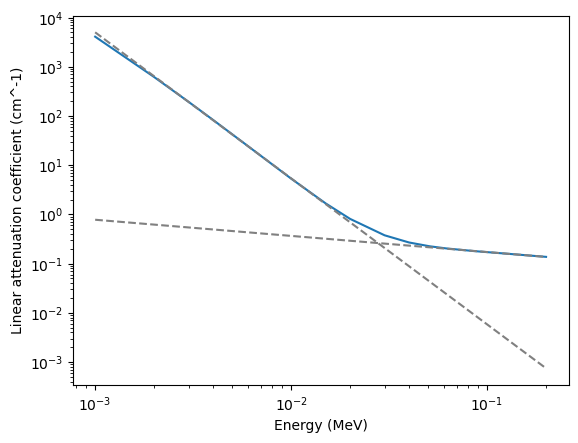

Transition Region about energies: [0.02, 0.06]


In [57]:
from scipy.optimize import curve_fit

energies = material.mev
coeff_w = material.coeff('Water')


# Plot asymptotic behavior
x1, y1 = energies[5:20], coeff_w[5:20]
x2, y2 = energies[60:], coeff_w[60:]

def power_law(x, a, b):
    return a * x**b

popt1,_= curve_fit(power_law, x1, y1)
a1, b1 = popt1
popt2,_= scipy.optimize.curve_fit(power_law, x2, y2)
a2, b2 = popt2

y1_fit = power_law(energies, a1, b1)
y2_fit = power_law(energies, a2, b2)

plt.figure()
plt.loglog(energies, coeff_w, label='Water')
plt.loglog(energies, y1_fit, linestyle='--', color='grey')
plt.loglog(energies, y2_fit, linestyle='--', color='grey')
plt.xlabel('Energy (MeV)')
plt.ylabel('Linear attenuation coefficient (cm^-1)')
plt.show()

print(f"Transition Region about energies: {[energies[19], energies[59]]}")

Use ct_detect to investigate attentuation of a material (water) with different depths. <br>
Compare different source photon types, all with peak energy at 100kVp and filtered by 2mmAl.

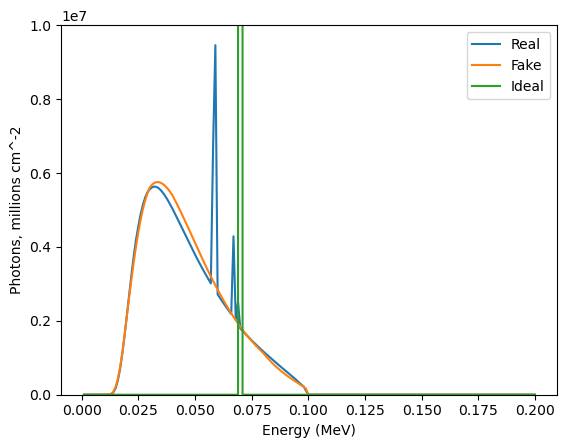

In [58]:
s_real = source.photon('100kVp, 2mm Al')
s_fake = fake_source(energies, 0.1, material.coeff('Aluminium'), 2)
s_ideal = fake_source(energies, 0.1, material.coeff('Aluminium'), 2, 'ideal')

plt.figure()
plt.plot(energies, s_real, label='Real')
plt.plot(energies, s_fake, label='Fake')
plt.plot(energies, s_ideal, label='Ideal')
plt.xlabel('Energy (MeV)')
plt.ylabel('Photons, millions cm^-2')
plt.ylim(0,10**7)
plt.legend()
plt.show()


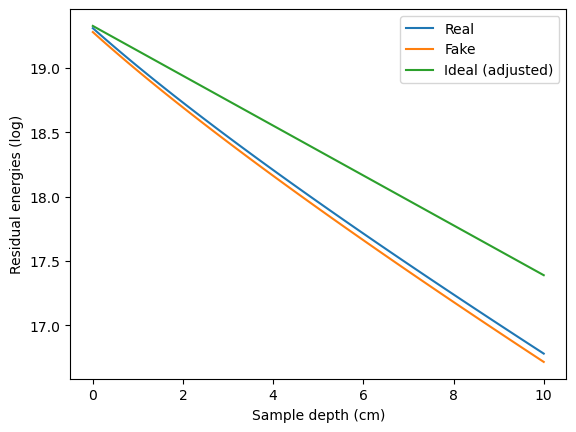

Ideal source residual energies are adjusted to match real source residual energies


In [59]:
depth_ary = np.arange(0, 10.1, 0.1)
y_real = ct_detect(s_real, material.coeff('Water'), depth_ary, 1) # FIXME: set all mas to 1 for now
y_fake = ct_detect(s_fake, material.coeff('Water'), depth_ary, 1)
y_ideal = ct_detect(s_ideal, material.coeff('Water'), depth_ary, 1)

plt.figure()
plt.plot(depth_ary, np.log(y_real), label='Real')
plt.plot(depth_ary, np.log(y_fake), label='Fake')
plt.plot(depth_ary, np.log(y_ideal)-3.7, label='Ideal (adjusted)')
plt.xlabel('Sample depth (cm)')
plt.ylabel('Residual energies (log)')
plt.legend()
plt.show()

print("Ideal source residual energies are adjusted to match real source residual energies")

Compare different materials.

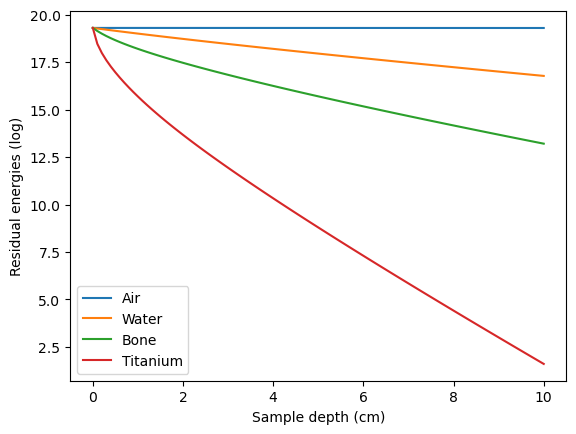

In [62]:
# Using a real source
s_real = source.photon('100kVp, 2mm Al')
y_air = ct_detect(s_real, material.coeff('Air'), depth_ary, 1)
y_water = ct_detect(s_real, material.coeff('Water'), depth_ary, 1)
y_bone = ct_detect(s_real, material.coeff('Bone'), depth_ary, 1)
y_ti = ct_detect(s_real, material.coeff('Titanium'), depth_ary, 1)

plt.figure()
plt.plot(depth_ary, np.log(y_air), label='Air')
plt.plot(depth_ary, np.log(y_water), label='Water')
plt.plot(depth_ary, np.log(y_bone), label='Bone')
plt.plot(depth_ary, np.log(y_ti), label='Titanium')
plt.legend()
plt.xlabel('Sample depth (cm)')
plt.ylabel('Residual energies (log)')
plt.show()

# 4.3 Experiments

Construct a sinogram (residual energies) using ct_scan function for:
- 2. impulse at origin
- 2. impulse with offset
- 1. disk
- 3. hip implant

In [94]:
s_ideal = fake_source(energies, 0.1, material.coeff('Aluminium'), 2, 'ideal')
scale = 0.1 # 0.1 cm per pixel
angles = 256

In [95]:
p2_origin = ct_phantom(material.name, 256, 2, 'Titanium')
p2_offset = ct_phantom(material.name, 256, 2, 'Titanium', [20,20])
y2_origin = ct_scan(s_ideal, material, p2_origin, scale, angles)
y2_offset = ct_scan(s_ideal, material, p2_offset, scale, angles)

Scanning angle: 256   
Scanning angle: 256   


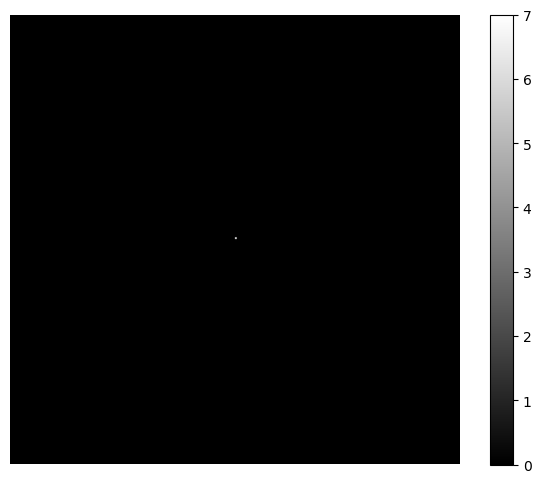

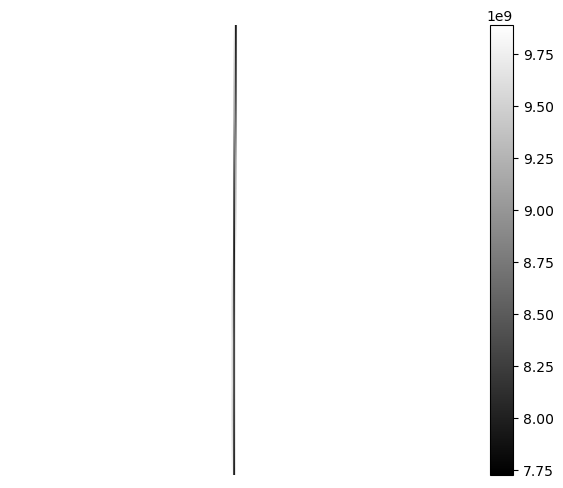

In [96]:
draw(p2_origin)
draw(y2_origin)

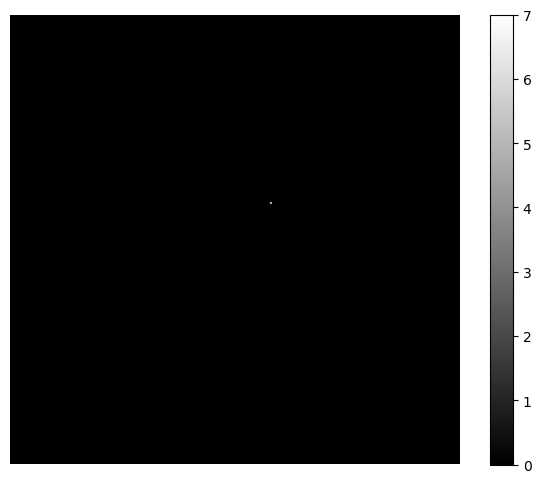

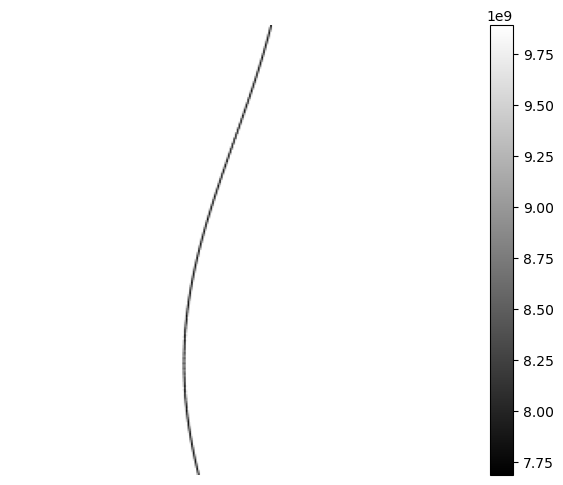

In [84]:
draw(p2_offset)
draw(y2_offset)

In [97]:
p1 = ct_phantom(material.name, 256, 1, 'Water')
y1 = ct_scan(s_ideal, material, p1, scale, angles)

Scanning angle: 256   


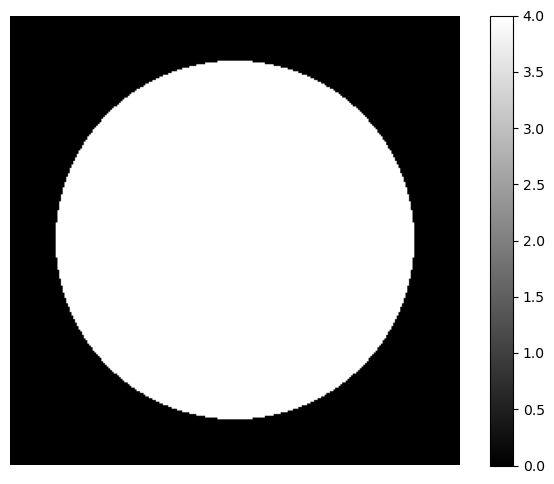

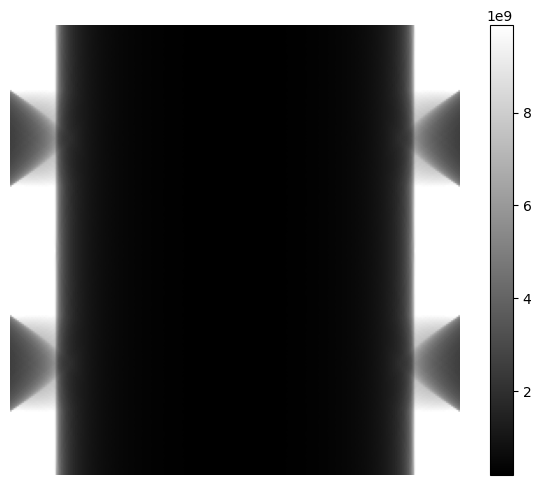

In [99]:
draw(p1)
draw(y1)

In [93]:
p3 = ct_phantom(material.name, 256, 3, 'Titanium')
y3 = ct_scan(s_ideal, material, p3, scale, angles)

Scanning angle: 256   


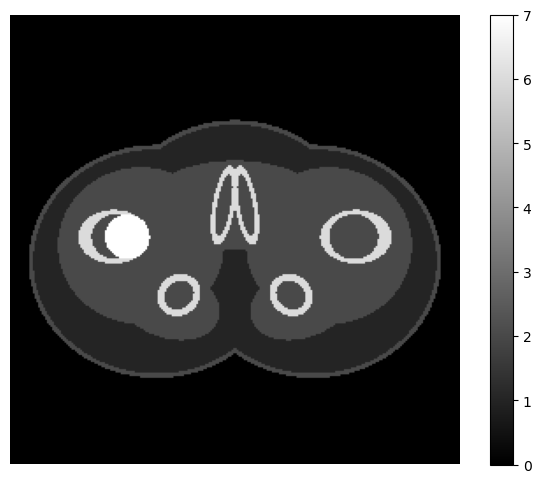

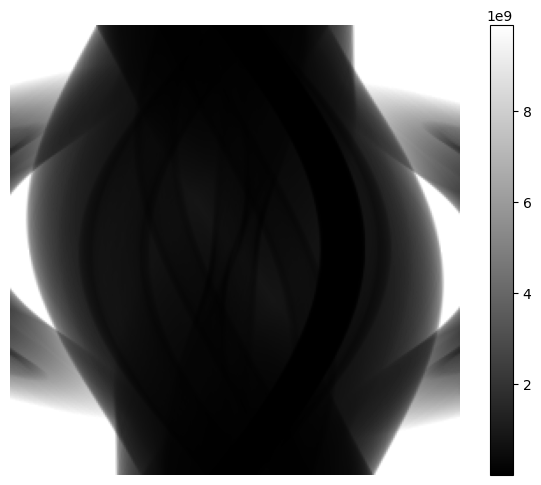

In [79]:
draw(p3)
draw(y3)

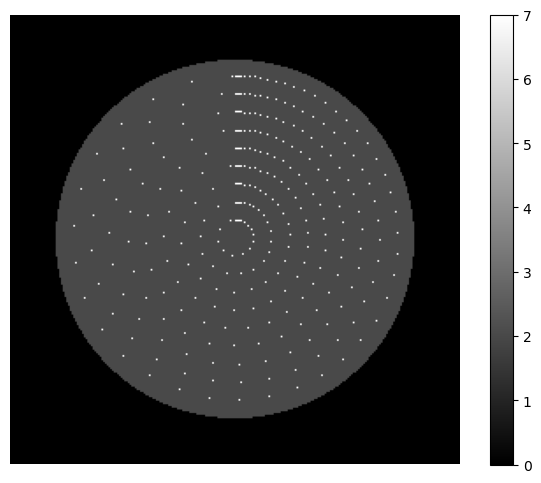

In [69]:
p = ct_phantom(material.name, 256, 8, 'Titanium')
draw(p)

Investigate effect of number of angles.

Investigate effect of interpolation technique.